## Preguntas
1. ¿Cualquier fecha en la variable objetivo EndDate indicaría que el cliente canceló su plan?
2. Si la información del contrato es válida a partir de febrero del 2020 ¿Debemos filtrar datos anteriores a esa fecha o es posible trabajar con la totalidad de datos proporcionados?
3. En caso de contar con valores ausentes ¿Podemos considerar que son un error de datos o asumimos que no existe un plan para ese cliente?
4. ¿Los datos de la variable objetivo están balanceados? En caso de existir un desequilibrio de clases ¿es posible utilizar tecnicas para corregir esto como oversampling o undersampling?
5. ¿Se debe priorizar algún servicio para las promociones?
6. ¿El modelo será empleado con un gran volumen de datos? ¿Se necesita un modelo que pueda ser ejecutado en un entorno computacional básico o se cuenta con GPU o un entorno de mayor capacidad de procesamiento?

# Proyecto final - Interconnect

## Descripción del proyecto

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

#### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.



## 1. Inicialización

In [2]:
#Cargar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats as st

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras import callbacks

## 2. Cargar datos 


In [ ]:
df_contract = pd.read_csv('C:/Users/Daniela/Documents/Tripleten/Proyecto final/dataset/contract.csv')
df_personal = pd.read_csv('C:/Users/Daniela/Documents/Tripleten/Proyecto final/dataset/personal.csv')
df_internet = pd.read_csv('C:/Users/Daniela/Documents/Tripleten/Proyecto final/dataset/internet.csv')
df_phone = pd.read_csv('C:/Users/Daniela/Documents/Tripleten/Proyecto final/dataset/phone.csv')

## 3. Preprocesamiento de datos
Convertir las columnas a los tipos de datos correctos y limpiar los datos tratando valores ausentes y duplicados.

In [4]:
# Observar tipos de datos y valores ausentes
print('Información de contrato')
print(df_contract.info())
print('')

print('Datos personales del cliente')
print(df_personal.info())
print('')

print('Información sobre servicios de internet')
print(df_internet.info())
print('')

print('Información sobre servicios de teléfono')
print(df_phone.info())


Información de contrato
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Datos personales del cliente
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null

Se puede observar que no existen valores ausentes en ninguno de los dataframes presentados. Únicamente, se deberá cambiar el tipo de datos en las columnas BeginDate a datetime y TotalCharges a numeric. Sin embargo, al no contar con la misma cantidad de datos en todos los dataframes, se deberá tratar valores nulos posteriormente en la unión.

In [5]:
#Cambiar tipo de datos
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [6]:
#Unir dataframes
df = df_contract.merge(df_personal, on ='customerID', how ='left')
df = df.merge(df_internet, on ='customerID', how ='left')
df = df.merge(df_phone, on ='customerID', how ='left')

print(df.shape)
df.head()

(7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [7]:
#Verificar duplicados
print(df.duplicated().sum())

0


Se verificó la inexistencia de valores duplicados

In [8]:
#Verificar valores nulos NA
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Como se explicó anteriormente, la diferencia en la cantidad de datos de los distintos dataframes genera valores ausentes despues de la unión en las columnas de servicios de internet, servicios de teléfono y cargos totales, que serán tratados posteriormente.

In [9]:
#Comprobar valores en las columnas con mayor cantidad de NAN
print('InternetService:', df['InternetService'].unique())
print('OnlineSecurity:', df['OnlineSecurity'].unique())
print('OnlineBackup:', df['OnlineBackup'].unique())
print('DeviceProtection:', df['DeviceProtection'].unique())
print('TechSupport:', df['TechSupport'].unique())
print('StreamingTV:', df['StreamingTV'].unique())
print('StreamingMovies:', df['StreamingMovies'].unique())
print('MultipleLines:', df['MultipleLines'].unique())

InternetService: ['DSL' 'Fiber optic' nan]
OnlineSecurity: ['No' 'Yes' nan]
OnlineBackup: ['Yes' 'No' nan]
DeviceProtection: ['No' 'Yes' nan]
TechSupport: ['No' 'Yes' nan]
StreamingTV: ['No' 'Yes' nan]
StreamingMovies: ['No' 'Yes' nan]
MultipleLines: [nan 'No' 'Yes']


Observando los valores únicos en las columnas que presentan datos nulos y con el conocimiento de que los dataframes no tenían las mismas dimensiones, se puede afirmar que estos valores ausentes corresponden a clientes que no cuentan con los servicios de internet y telefonía según corresponda.

In [10]:
#Tratamiento de valores nulos
median_charges = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median_charges)

df['MultipleLines'] = df['MultipleLines'].fillna('No_phone_service')

internet_services = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in internet_services:
    df[col] = df[col].fillna('no_internet_service')


#Verificación
print(df.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


Se trataron los valores nulos de la siguiente manera:
- Los datos en la columna 'TotalCharges' se completaron con la mediana del total de cargos ya que solo eran 11 casos.
- Los datos nulos en la columna 'MultipleLines' fueron completados con No_phone_service.
- Los datos nulos en las columnas de servicios de internet ('InternetService', 'OnlineSecurity', 'OnlineBackup', DeviceProtection',
  'TechSupport', 'StreamingTV', 'StreamingMovies') se completaron con no_internet_service.

## 3.1. Ingeniería de características

In [11]:
#Crear la variable objetivo a partir de EndDate
df['target'] = (df['EndDate'] != 'No').astype(int)

A partir de la variable EndDate se crea la variable objetivo "target" donde 1 corresponde a los clientes que cancelaron sus planes (aquellos con EndDate distinto de No) y 0 a los clientes que no dan de baja su servicio.

In [12]:
#Crear la variable tenure correspondiente a la permanencia del cliente en meses
fecha_corte = pd.to_datetime('2020-02-01')
df['EndDate_dt'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['tenure'] = np.where(df['EndDate_dt'].isna(), fecha_corte - df['BeginDate'], 
                        df['EndDate_dt'] - df['BeginDate'])
df['tenure'] = (df['tenure'].dt.days)/30

C:\Users\Daniela\AppData\Local\Temp\ipykernel_2188\3311964739.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EndDate_dt'] = pd.to_datetime(df['EndDate'], errors='coerce')


Se crea la variable tenure que corresponde a la duración del cliente en meses

In [13]:
#Eliminar columnas innecesarias
df = df.drop(['customerID', 'EndDate', 'EndDate_dt', 'BeginDate'], axis=1)

## 4. EDA

### 4.1. Análisis de distribuciones

In [14]:
#Analizar el equilibrio de clases
print(df['target'].value_counts(normalize=True))

target
0    0.73463
1    0.26537
Name: proportion, dtype: float64


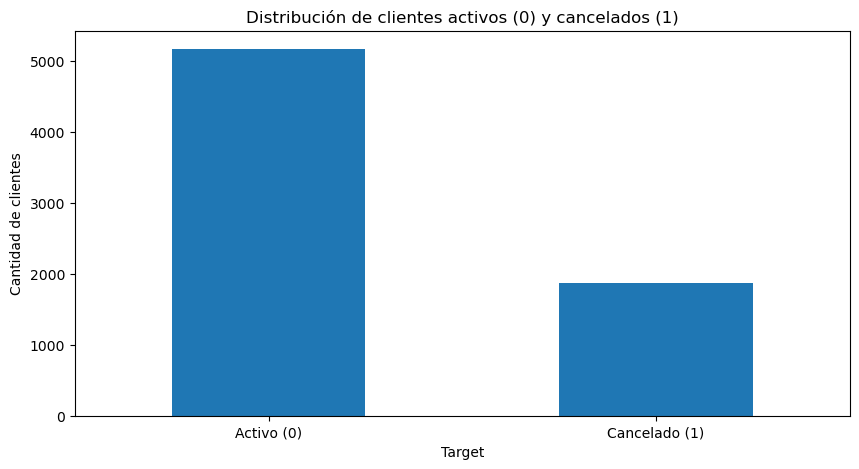

In [15]:
#Distribución de la variable target
plt.figure(figsize = (10,5))
df['target'].value_counts().plot(kind='bar')
plt.title('Distribución de clientes activos (0) y cancelados (1)')
plt.xlabel('Target')
plt.ylabel('Cantidad de clientes')
plt.xticks([0, 1], ['Activo (0)', 'Cancelado (1)'], rotation=0)
plt.show()

Analizando la distribución de la variable target, se observa que existe un evidente desequilibrio de clases con un predominio de la clase 0. Se cuenta con un 73% de datos de clientes activos y solo un 27% de clientes cancelados, por este motivo, es necesario considerar la aplicación de alguna técnica para equilibrar las clases.

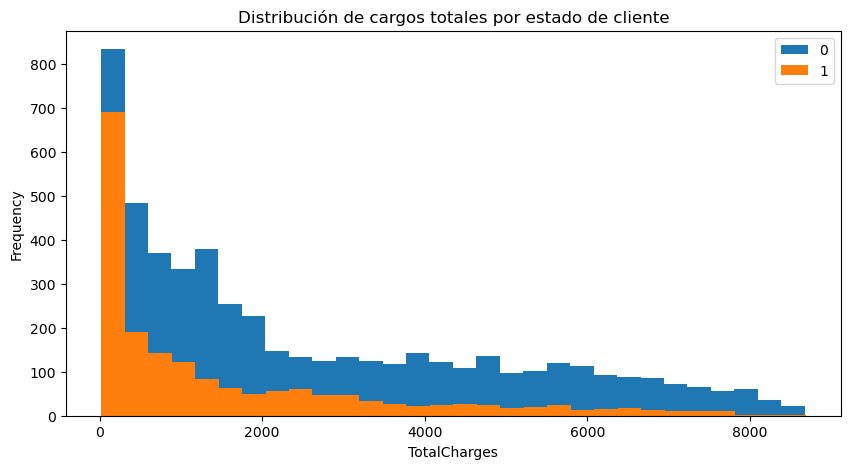

In [16]:
#Distribución de cargos totales por clase target
dist = df.groupby('target')['TotalCharges']
plt.figure(figsize = (10,5))
dist.plot(kind='hist', bins=30)
plt.xlabel('TotalCharges')
plt.title('Distribución de cargos totales por estado de cliente')
plt.legend()
plt.show()

Se evidencia que la mayoría de clientes que cancelan sus planes tienen cobros menores a 2000, esto puede indicar que son clientes nuevos o que tienen pocos servicios contratados al momento de cancelar. De igual manera, se observa que a medida que los cargos incrementan la proporcion de clientes cancelados es menor, por lo tanto existe menos probabilidad de cancelación en clientes con cobros mayores pero también podría deberse al desequilibrio de clases en el conjunto de datos. Los clientes activos varían en mayor frecuencia respecto a los cobros totales, a pesar de existir una mayoría con cobros totales menores a 2000.

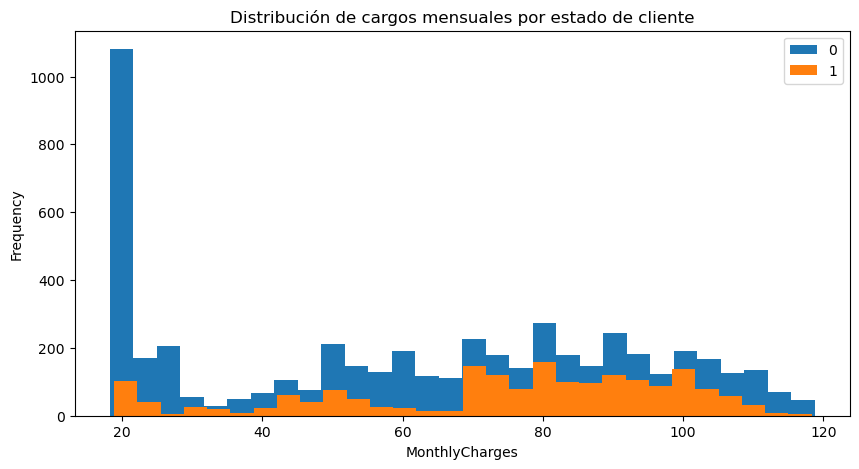

In [17]:
#Distribución de cargos mensuales por clase target
dist = df.groupby('target')['MonthlyCharges']
plt.figure(figsize = (10,5))
dist.plot(kind='hist', bins=30)
plt.xlabel('MonthlyCharges')
plt.title('Distribución de cargos mensuales por estado de cliente')
plt.legend()
plt.show()

Se observa que los clientes con pagos mensuales entre 70 y 100 son más propensos a cancelar. A pesar de identificar la mayor cantidad de clientes activos en el segmento más bajo de cobros mensuales, se observa una proporción significativa de clientes cancelados en ese rango de cobros, esto puede deberse a clientes insatisfechos con los servicios o a aquellos que solo buscaban una prueba básica.

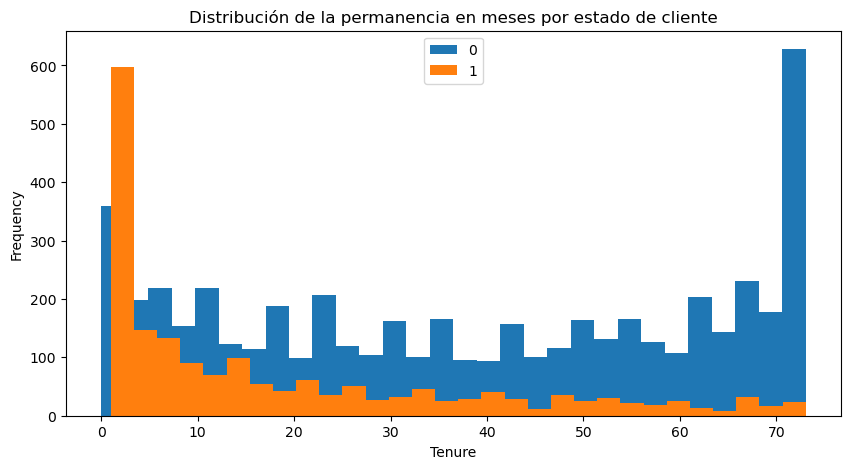

In [18]:
#Distribución de la duración del contrato por clase target
dist = df.groupby('target')['tenure']
plt.figure(figsize = (10,5))
dist.plot(kind='hist', bins=30)
plt.xlabel('Tenure')
plt.title('Distribución de la permanencia en meses por estado de cliente')
plt.legend()
plt.show()

Se evidencia una tendencia de cancelación temprana que puede deberse a expectativas no cumplidas o periodos de prueba, con la mayoría de cancelaciones en permanencias menores a 10 meses. Por otra parte, se observa menor probabilidad de cancelación en clientes con permanencia mayor a 30 meses.

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


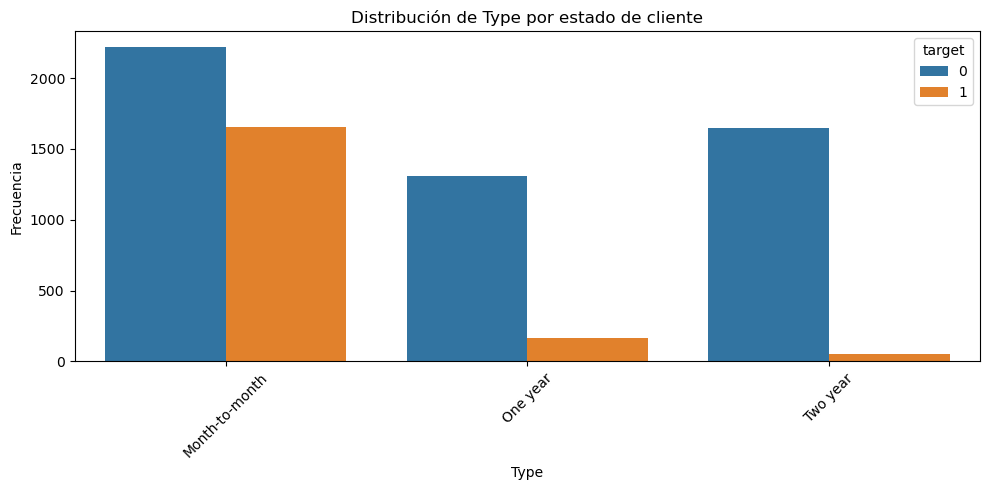

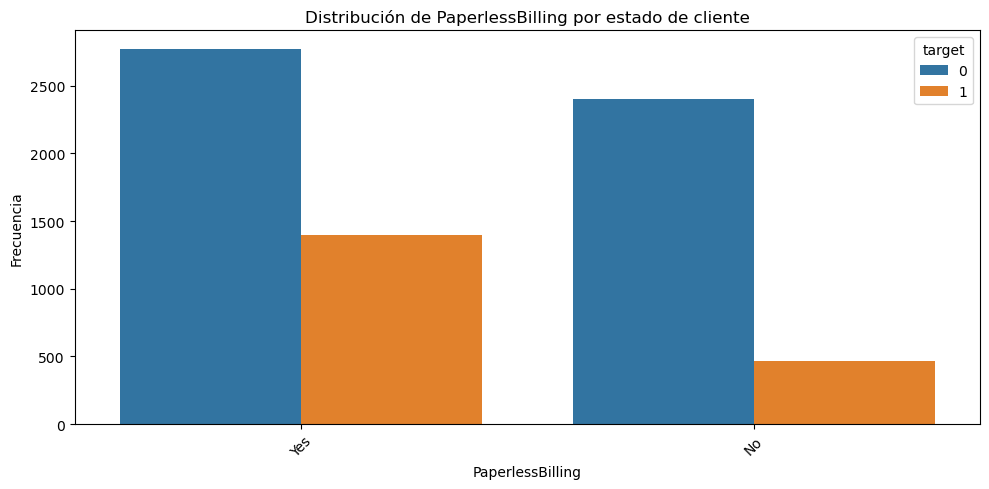

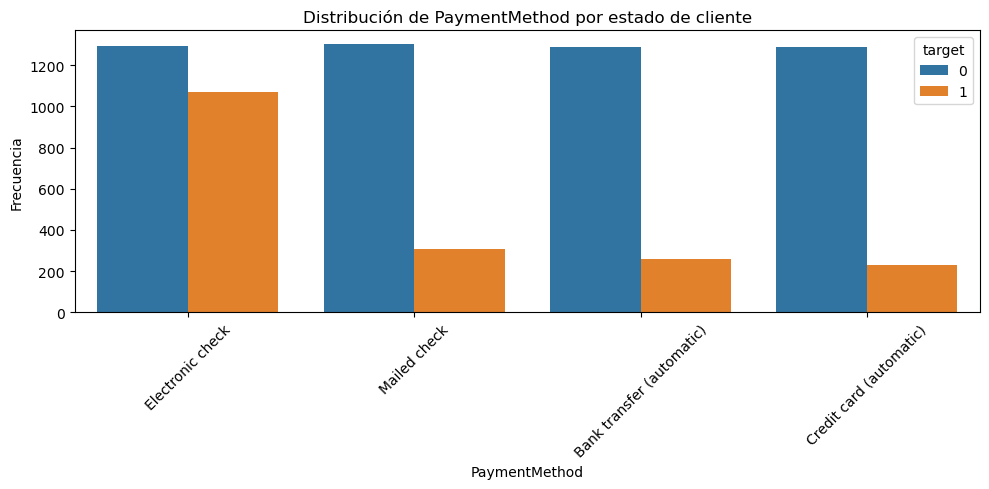

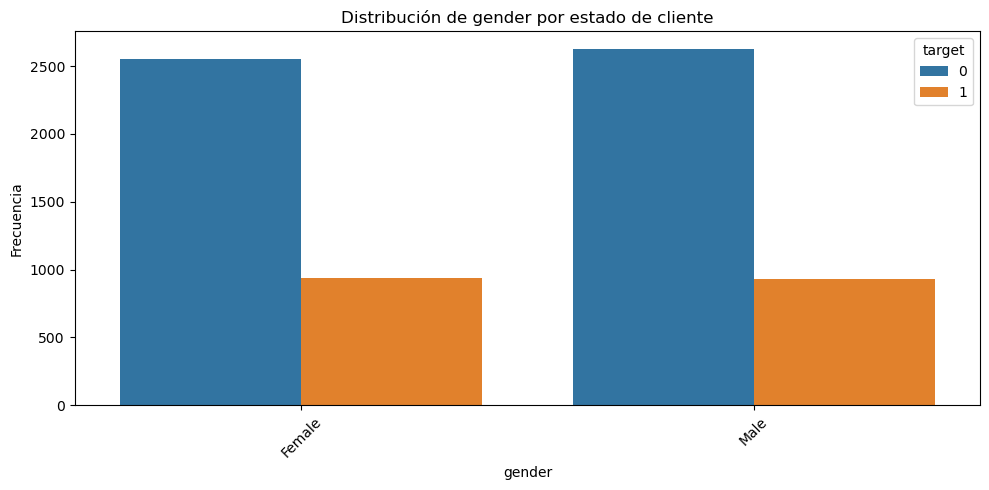

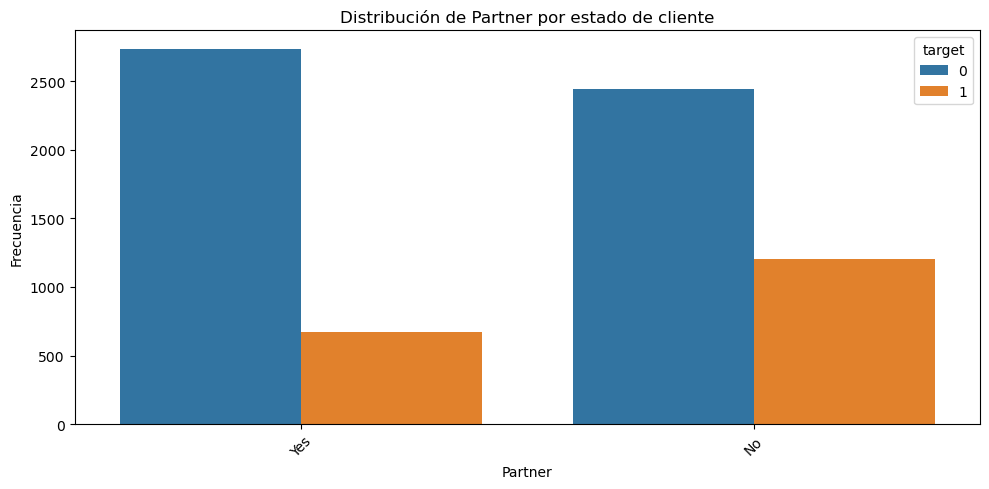

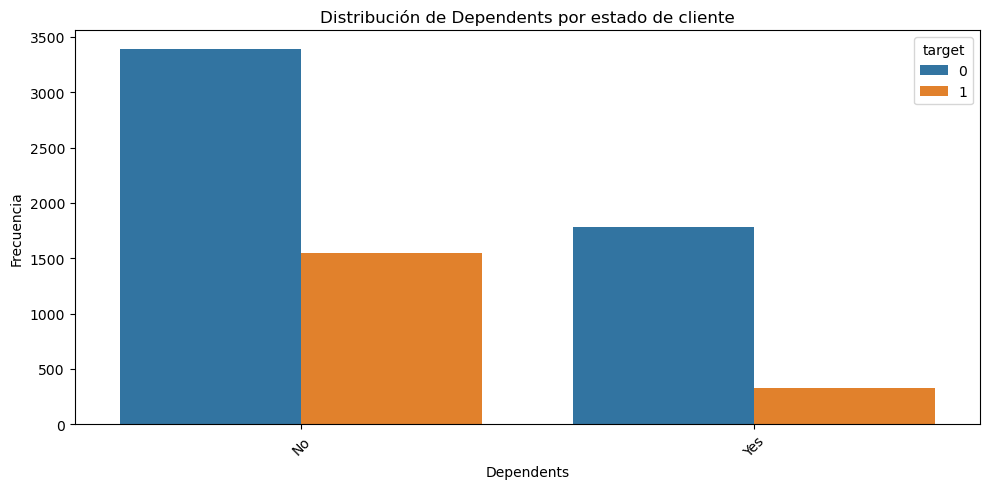

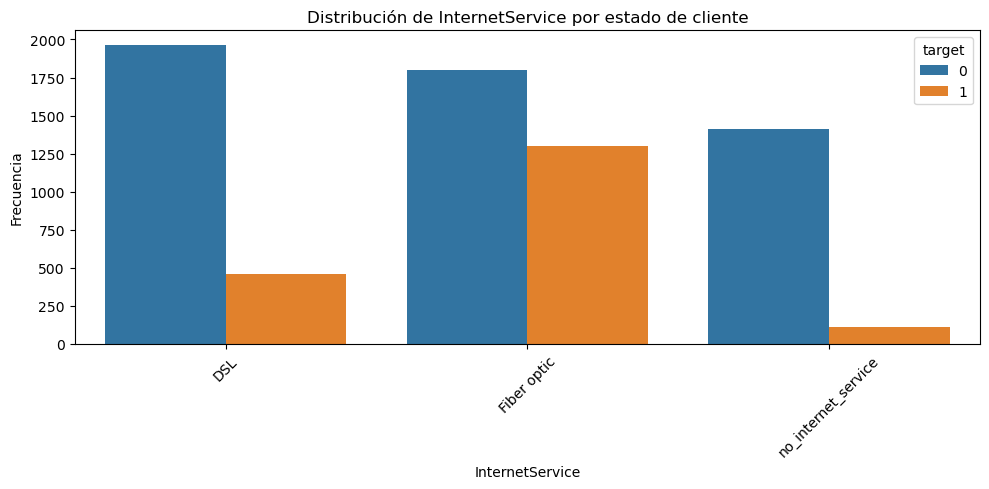

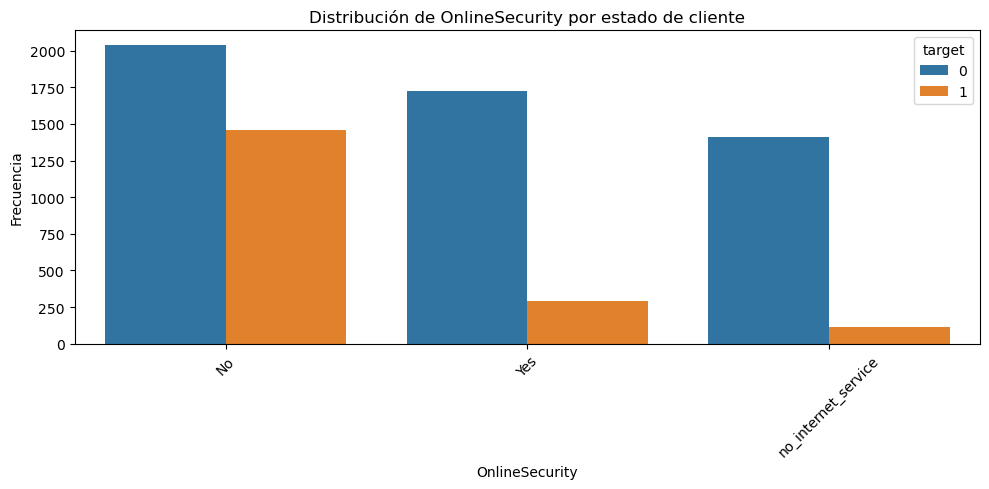

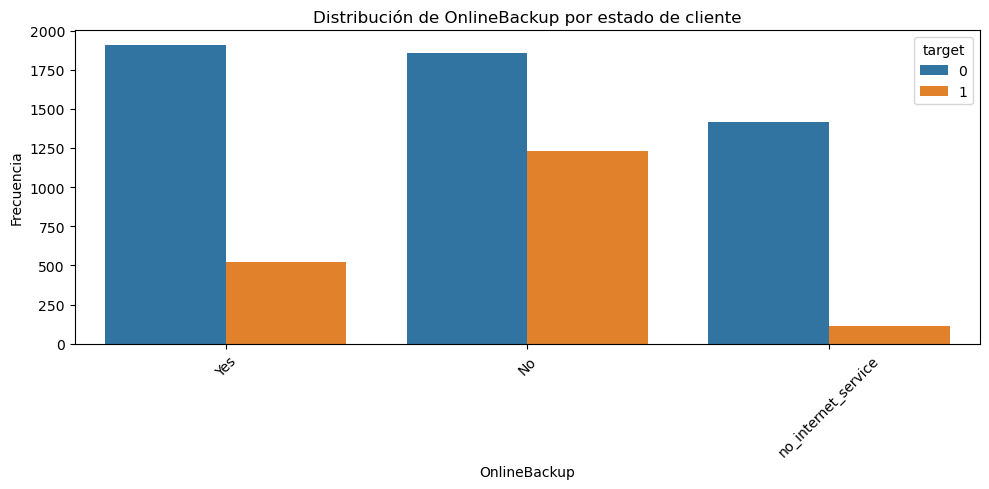

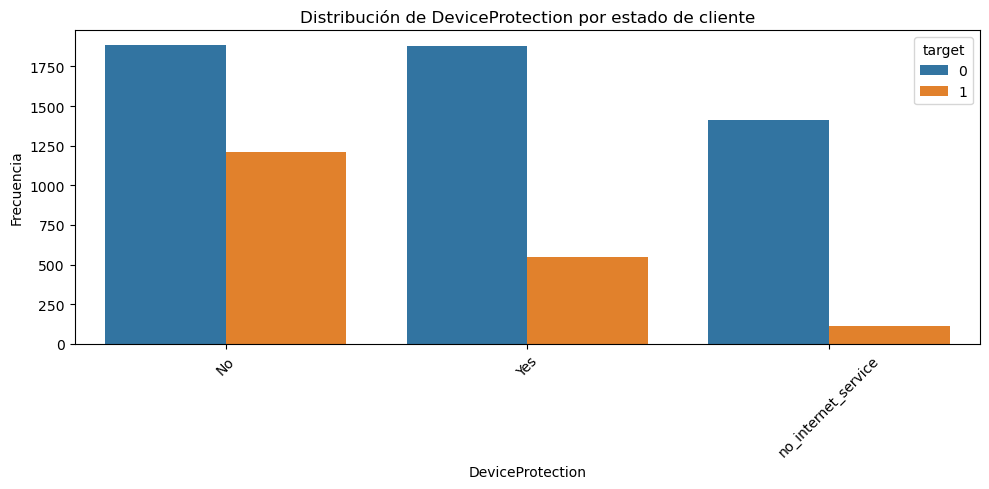

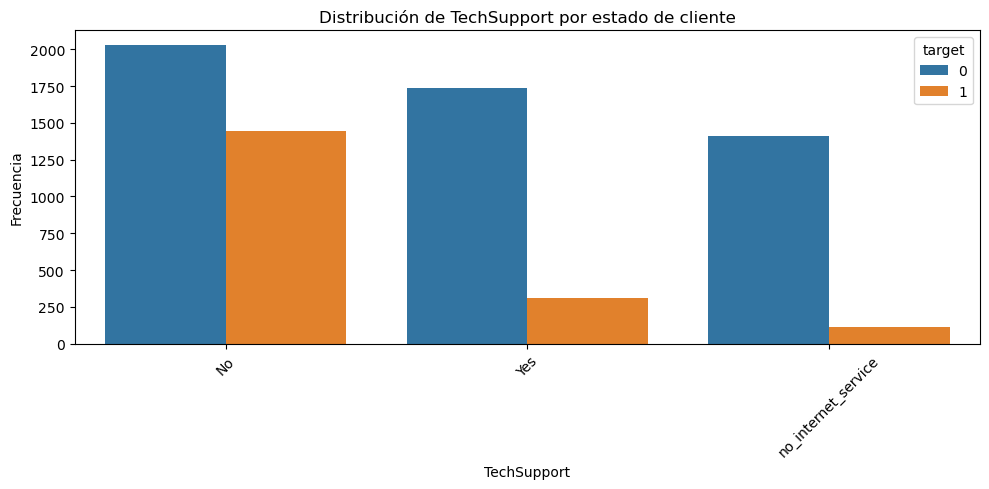

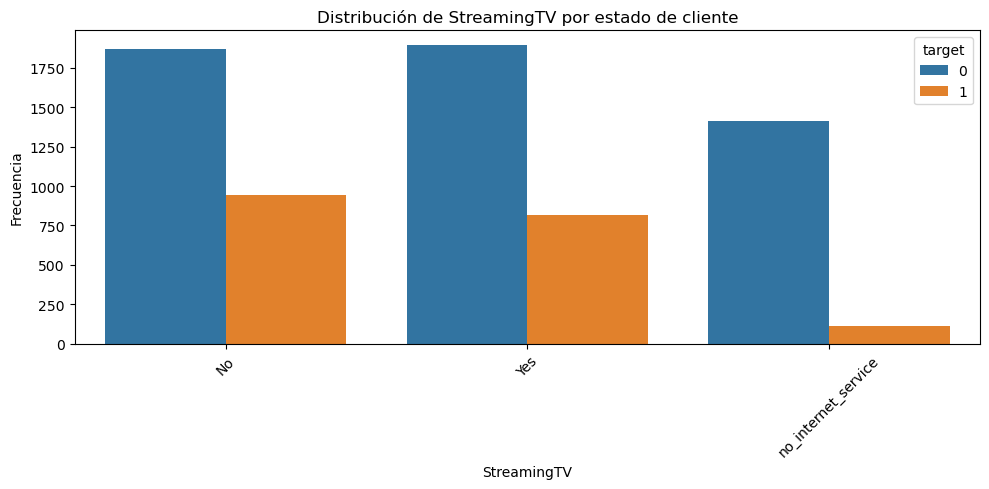

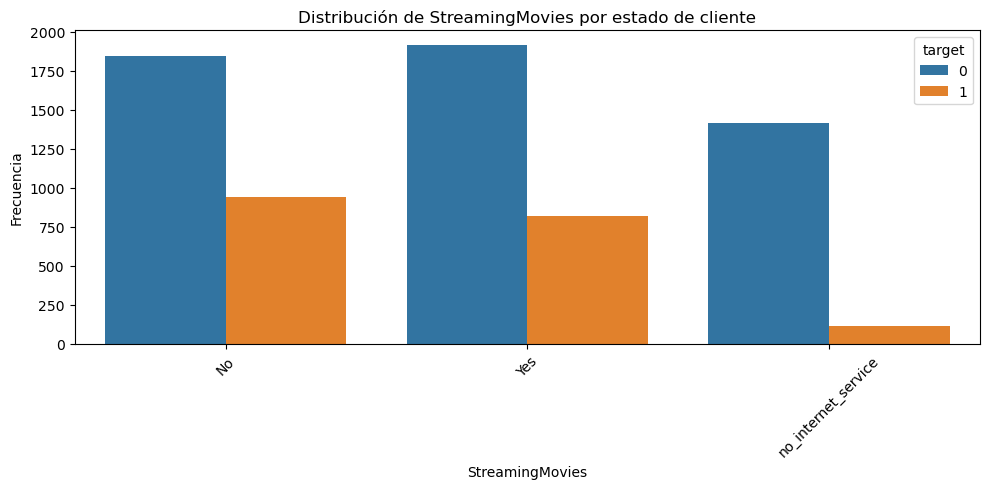

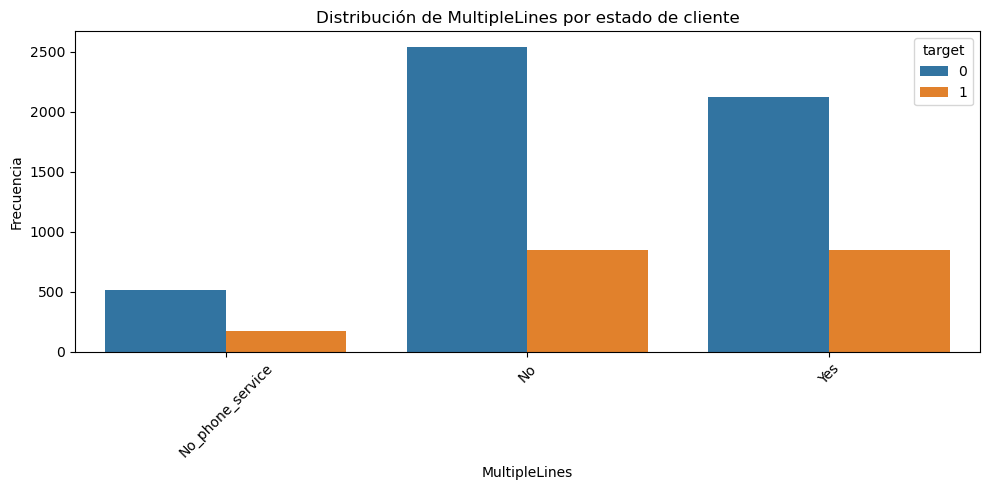

In [18]:
#Distribución de variables categóricas por clase target
cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(cat_columns)

for col in cat_columns:
    plt.figure(figsize = (10,5))
    sns.countplot(data=df, x=col, hue='target')
    plt.title(f'Distribución de {col} por estado de cliente')
    plt.xlabel(f'{col}')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- Tipo de contrato: Existe un riesgo de cancelación masiva en los contratos mes a mes, comprobando la tendencia de cancelación temprana en la permanencia de los clientes. Esta situación baja drásticamente para contratos de un año y dos, por lo que la estrategia comercial debería enfocarse en clientes con mayor predisposición a un compromiso a largo plazo.
- Método de pago: Se identificó mayor proporción de clientes cancelados con pago electrónico y con un tipo PaperlessBilling.
- Género: El género no parece ser un factor determinante en la cancelación de planes, al presentar distribuciones similares tanto para mujeres como para hombres.
- Otras variables demográficas: Existe mayor frecuencia de clientes que cancelan sus planes en aquellos clientes que no tienen pareja ni dependientes.
- Servicios de internet: Se observa mayor frecuencia de clientes cancelados en clientes con Fibra optica.
- Servicios complementarios de internet: La frecuencia de clientes cancelados es significativamente mayor en aquellos clientes que no cuentan con servicios complementarios como 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'.
- Múltiples líneas: Se observa una distribución similar en clientes con y sin multiples líneas en cuanto a cancelaciones, sin embargo, se puede evidenciar mayor frecuencia en clientes activos que no cuentan con este servicio.

### 4.2. Correlaciones

<Axes: >

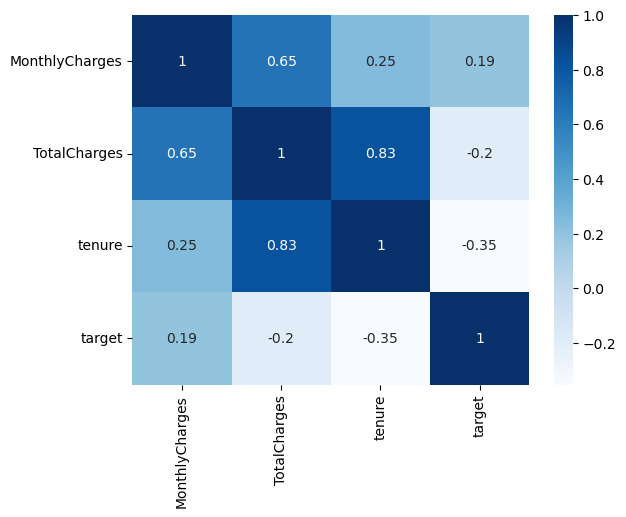

In [19]:
#Correlaciones de la variable objetivo y las variables numéricas
corr = df[['MonthlyCharges', 'TotalCharges', 'tenure', 'target']].corr()
sns.heatmap(corr, annot=True, cmap='Blues')

El mapa de calor con las correlaciones entre la variable objetivo y las variables numéricas indica lo siguiente:
- Existe una correlación moderada negativa entre la permanencia del cliente y el abandono, es decir, que a mayor permanencia menor probabilidad de abandono.
- A mayores cargos totales menor probabilidad de abandono, con una correlación negativa de -0.2.
- Se observa una correlación levemente positiva entre los cargos mensuales y el abandono, a mayores cargos mensuales existe cierta probabilidad de abandono.

Las correlaciones analizadas confirman los hallazgos observados en las distribuciones.

### 4.3. Análisis de valores atípicos

C:\Users\Daniela\AppData\Local\Temp\ipykernel_16876\1796691672.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='target', y='MonthlyCharges',  palette='viridis')


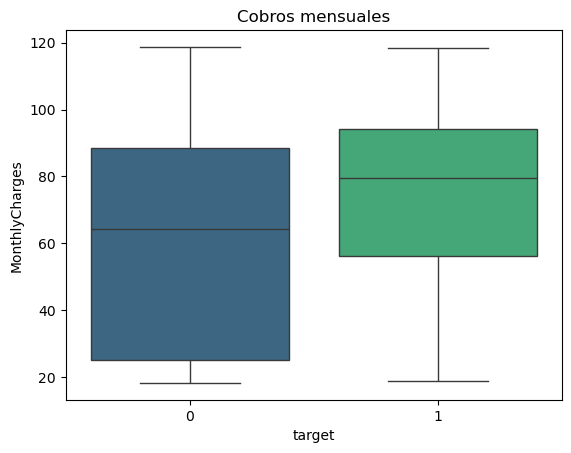

In [22]:
#Generar un gráfico boxplot a fin de analizar la existencia de valores atípicos en los cobros mensuales
plt.figure()
sns.boxplot(data=df, x='target', y='MonthlyCharges',  palette='viridis')
plt.title('Cobros mensuales')
plt.show()

No se observan valores atípicos en la distribución de los cargos mensuales. Se evidencia que la mediana de los cargos mensuales es mayor en clientes que cancelan (aproximadamente 80), pudiendo concluir que los clientes cancelados tienden a tener cargos mensuales más elevados. El 75% de los clientes cancelados paga más que el 25% de los clientes activos.

C:\Users\Daniela\AppData\Local\Temp\ipykernel_16876\3250141727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='target', y='TotalCharges',  palette='viridis')


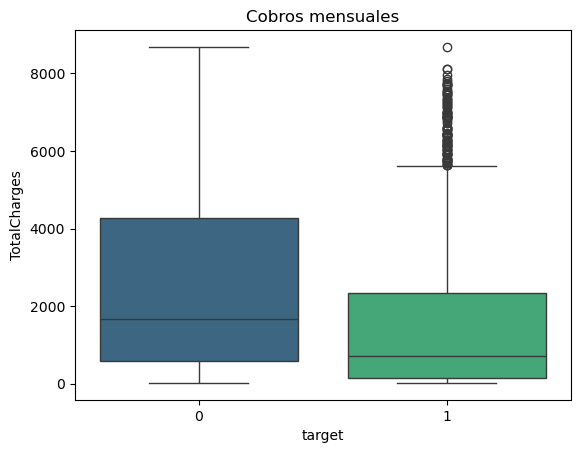

In [23]:
#Generar un gráfico boxplot a fin de analizar la existencia de valores atípicos en los cobros totales
plt.figure()
sns.boxplot(data=df, x='target', y='TotalCharges',  palette='viridis')
plt.title('Cobros mensuales')
plt.show()

Es evidente que existe un patrón de abandono en clientes con cargos totales más bajos, por una permanencia menor. Sin embargo, se observan valores atípicos que afirmarían que se cuenta con clientes con cargos totales elevados y por ende mayor antigüedad que deciden, de igual manera, cancelar sus servicios.

### 4.4. Prueba de hipótesis

#### 4.4.1. Cargos mensuales
$H_0$: No existe una diferencia significativa en los cobros mensuales promedio para clientes activos y clientes que cancelaron su plan.

$H_1$: Existe una diferencia significativa en los cobros mensuales promedio para clientes activos y clientes que cancelaron su plan.

In [22]:
alpha = 0.05

Monthlycharges_activos = df[df['target']==0]['MonthlyCharges']
Monthlycharges_cancelados = df[df['target']==1]['MonthlyCharges']

#Prueba de varianza
levene = st.levene(Monthlycharges_activos, Monthlycharges_cancelados)
print('valor p levene:', levene.pvalue)

if levene.pvalue < alpha:
    print("Se rechaza la hipótesis nula: las varianzas no son iguales (heterocedasticidad).")
else:
    print("No se rechaza la hipótesis nula: las varianzas son iguales (homocedasticidad).")

valor p levene: 1.0261244899421871e-78
Se rechaza la hipótesis nula: las varianzas no son iguales (heterocedasticidad).


In [23]:
#Prueba de hipotesis
results = st.ttest_ind(Monthlycharges_activos, Monthlycharges_cancelados, equal_var=False)
print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print('Rechazamos la hipotesis nula')
else:
    print('No podemos rechazar la hipotesis nula')

valor p: 8.59244933154705e-73
Rechazamos la hipotesis nula


La prueba de hipótesis indica que los cargos mensuales promedio difiere significativamente para clientes activos y cancelados, comprobando lo observado anteriormente, los clientes que abandonan tienden a pagar mayores cargos mensuales.
La variabilidad y disperción del cargo mensual es diferente para ambos grupos, afectando de manera distinta a clientes activos y a aquellos que cancelan sus servicios.

#### 4.4.2. Antigüedad del cliente
$H_0$: El promedio de antigüedad o permanencia para clientes activos y clientes que cancelaron su plan es el similar.

$H_1$: Existe una diferencia significativa en el promedio de antigüedad para clientes activos y clientes que cancelaron su plan.

In [19]:
alpha = 0.05

tenure_activos = df[df['target']==0]['tenure']
tenure_cancelados = df[df['target']==1]['tenure']

#Prueba de varianza
levene = st.levene(tenure_activos, tenure_cancelados)
print('valor p levene:', levene.pvalue)

if levene.pvalue < alpha:
    print("Se rechaza la hipótesis nula: las varianzas no son iguales (heterocedasticidad).")
else:
    print("No se rechaza la hipótesis nula: las varianzas son iguales (homocedasticidad).")

valor p levene: 3.304133529649551e-90
Se rechaza la hipótesis nula: las varianzas no son iguales (heterocedasticidad).


In [20]:
#Prueba de hipotesis
results = st.ttest_ind(tenure_activos, tenure_cancelados, equal_var=False)
print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print('Rechazamos la hipotesis nula')
else:
    print('No podemos rechazar la hipotesis nula')

valor p: 3.019523557831003e-233
Rechazamos la hipotesis nula


Es evidente que la antigüedad promedio es significativamente diferente en clientes que cancelan y los clientes activos.
Se corrobora el resultado de la correlación (-0.35), en promedio la antigüedad de permanencia de los clientes que cancelan sus servicios es menor a la antigüedad de los clientes activos o retenidos.

## 5. Entrenamiento y evaluación del modelo

### 5.1. Dividir el conjunto de datos

Se divide el conjunto de datos en entrenamiento y prueba con un test_size de 25%. 
Al tener distintas variables numéricas se aplicará StandardScaler para estandarizar la escala de las características. De igual manera, se aplicará OneHotEncoder a las variables catogóricas a fin de generar variables binarias. 

In [21]:
#Dividir el conjunto de datos en entrenamiento y prueba
features = df.drop('target', axis=1)
target = df['target']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

#Columnas numéricas y categóricas
num_columns = ['MonthlyCharges', 'TotalCharges', 'tenure']
cat_columns = features.select_dtypes(include=['object', 'category']).columns.tolist()

#Preprocessor
preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), num_columns),
                                            ('cat', OneHotEncoder(), cat_columns)])

### 5.2. Crear funciones

Se crearán 3 funciones para entrenar, evaluar y graficar los resultados del modelo. Se aplicará la técnica SMOTE para el desequilibrio de clases y RandomSearchCV para encontrar los mejores hiperparámetros. Este último fue determinado por el costo computacional que tendría emplear GridSearchCv en su lugar.

In [22]:
#Crear la función de entrenamiento
def train_model(X_train, y_train, model, param_grid, preprocessor=preprocessor, random_state=12345):
    pipeline = ImbPipeline(steps=[('preprocess', preprocessor),
                               ('smote', SMOTE(random_state=random_state)),
                               ('clf', model)])

    #Mejorar hiperparámetros con RandomizedSearchCV
    model_rs = RandomizedSearchCV(pipeline,
                                param_grid,
                                cv=5,
                                scoring='roc_auc',
                                n_jobs=-1,
                                verbose=1)

    #Entrenar
    model_rs.fit(X_train, y_train)
    best_model = model_rs.best_estimator_

    print('Mejor modelo:', model_rs.best_params_)

    return best_model   

In [23]:
#Crear la función de evaluación
def evaluate_model(best_model, X_train, y_train, X_test, y_test):
    #Predicciones
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    train_proba = best_model.predict_proba(X_train)[:,1]
    test_proba = best_model.predict_proba(X_test)[:,1]
    
    #Evaluación
    auc_train = roc_auc_score(y_train, train_proba)
    auc_test = roc_auc_score(y_test, test_proba)
    acc_train = accuracy_score(y_train, train_pred)
    acc_test = accuracy_score(y_test, test_pred)

    metrics = {'AUC_ROC_train': auc_train,
                'AUC_ROC_test': auc_test,
                'Accuracy_train': acc_train,
                'Accuracy_test': acc_test}

    print(metrics)

    print('Classification report:')
    print(classification_report(y_test, test_pred))

    
    return test_pred, test_proba, metrics

In [31]:
#Crear la función que grafique la curva ROC
def roc_curve_gph(y_test, test_proba, model_name='LogisticRegression'):
    fpr, tpr, thresholds = roc_curve(y_test, test_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')
    plt.title(f'Roc Curve: {model_name} + SMOTE')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show() 

    return roc_auc
    

### 5.3. Modelos

#### 5.3.1. Modelo Dummy

In [26]:
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(X_train, y_train)

y_pred = dummy_model.predict(X_test)
y_proba = dummy_model.predict_proba(X_test)[:,1]

print('AUC_ROC_test:', roc_auc_score(y_test, y_proba))
print('Accuracy_test:', accuracy_score(y_test, y_pred))
print('Classification_report:')
print(classification_report(y_test, y_pred))

AUC_ROC_test: 0.49571420141040395
Accuracy_test: 0.6081771720613288
Classification_report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1287
           1       0.27      0.27      0.27       474

    accuracy                           0.61      1761
   macro avg       0.50      0.50      0.50      1761
weighted avg       0.61      0.61      0.61      1761



El modelo Dummy tiene un rendimiento para clasificar totalmente aleatorio (50%), no tienen una capacidad real de predicción.

#### 5.3.2. Logistic Regression

c:\Users\Daniela\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor modelo: {'clf__C': 1}
{'AUC_ROC_train': 0.8503171586567853, 'AUC_ROC_test': 0.8379387841413157, 'Accuracy_train': 0.7519878833775085, 'Accuracy_test': 0.7410562180579217}
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1287
           1       0.51      0.80      0.62       474

    accuracy                           0.74      1761
   macro avg       0.71      0.76      0.71      1761
weighted avg       0.80      0.74      0.75      1761



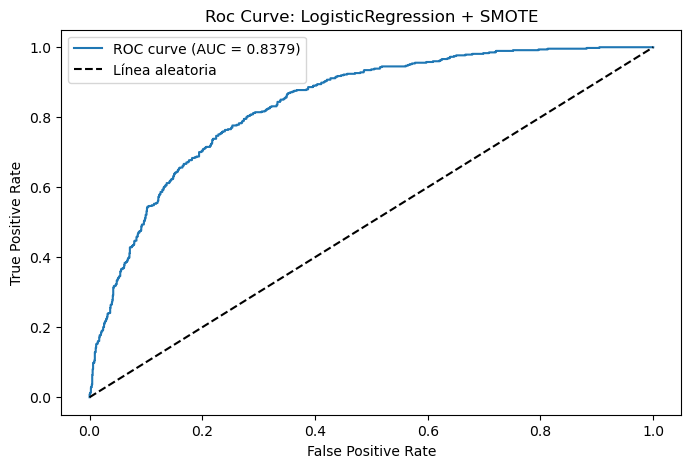

In [32]:
lr_model = LogisticRegression(random_state=12345, solver='liblinear')

lr_param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}

best_lr_model = train_model(X_train, y_train, lr_model, lr_param_grid)
lr_test_pred, lr_test_proba, lr_metrics = evaluate_model(best_lr_model, X_train, y_train, X_test, y_test)
lr_roc_auc = roc_curve_gph(y_test, lr_test_proba, model_name='LogisticRegression')

El modelo LogisticRegression + SMOTE tiene gran rendimiento para clasificar a los clientes (AUC = 83%). Logra identificar correctamente al 80% de los clientes que cancelan, sin embargo, sacrifica la precisión ya que de todas las veces que predijo a un cliente cancelado solo acertó el 51%, por lo que se invertiría en promoción en clientes que no cancelarían. El modelo es capaz de predecir correctamente al 74% de los clientes que activos y cancelados.
La curva ROC está por encima de la línea aleatoria, corroborando el AUC de 0.83.

#### 5.3.3. Árbol de decisión

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor modelo: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_depth': 5}
{'AUC_ROC_train': 0.8485141631004184, 'AUC_ROC_test': 0.8372453847137391, 'Accuracy_train': 0.764104505868989, 'Accuracy_test': 0.7444633730834753}
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1287
           1       0.52      0.76      0.62       474

    accuracy                           0.74      1761
   macro avg       0.71      0.75      0.71      1761
weighted avg       0.79      0.74      0.76      1761



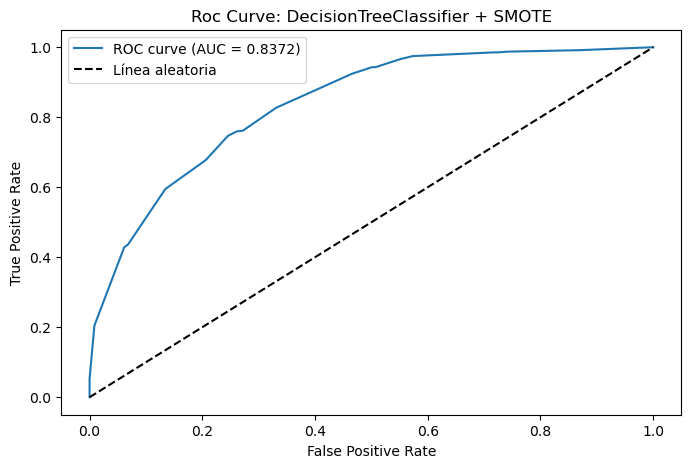

In [33]:
dt_model = DecisionTreeClassifier(random_state=12345)

dt_param_grid = {'clf__max_depth': [3, 5, 10, 20, None],
            'clf__min_samples_split': [2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4]}

best_dt_model = train_model(X_train, y_train, dt_model, dt_param_grid)
dt_test_pred, dt_test_proba, dt_metrics = evaluate_model(best_dt_model, X_train, y_train, X_test, y_test)
dt_roc_auc = roc_curve_gph(y_test, dt_test_proba, model_name='DecisionTreeClassifier')

El modelo tiene gran rendimiento al momento de clasificar a los clientes con un 83.72% de certeza. Tiene un accuracy significativo prediciendo correctamente el 74.4% de los clientes. Por otra parte, tiene un recall para la clase de cancelados del 76% pero una precisión relativamente baja con el 52%. La curva ROC muestra una alta tasa de verdaderos positivos y se encuentra muy por encima de la diagonal aleatoria.

#### 5.3.4. Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor modelo: {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10}
{'AUC_ROC_train': 0.9267061512826968, 'AUC_ROC_test': 0.8446400060324111, 'Accuracy_train': 0.853085952290799, 'Accuracy_test': 0.7825099375354913}
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1287
           1       0.58      0.71      0.64       474

    accuracy                           0.78      1761
   macro avg       0.73      0.76      0.74      1761
weighted avg       0.80      0.78      0.79      1761



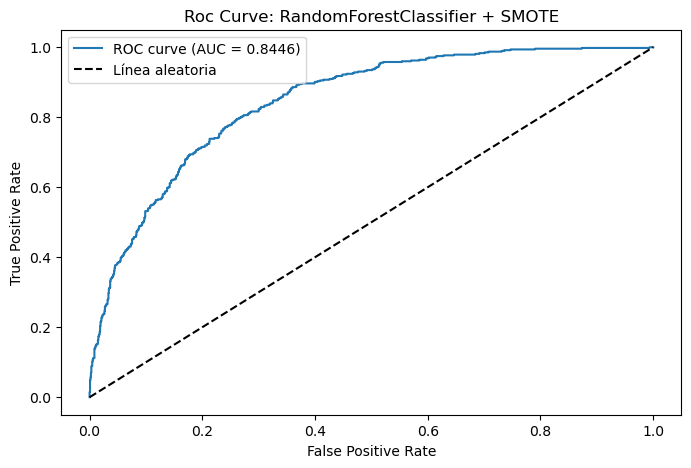

In [34]:
rf_model = RandomForestClassifier(random_state=12345)

rf_param_grid = {'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [None, 10, 20, 30],
            'clf__min_samples_split': [2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4]}

best_rf_model = train_model(X_train, y_train, rf_model, rf_param_grid)
rf_test_pred, rf_test_proba, rf_metrics = evaluate_model(best_rf_model, X_train, y_train, X_test, y_test)
rf_roc_auc = roc_curve_gph(y_test, rf_test_proba, model_name='RandomForestClassifier')

Se observa que el modelo RandomForest presenta cierto sobreajuste por la diferencia en las métricas AUC y Accuracy en el entrenamiento y el testeo. De todas formas, presenta un rendimiento muy bueno con un AUC de 84.4% y una capacidad de predecir correctamente a los clientes de 78.2%. El modelo logra identificar al 71% de los clientes que realmente cancelaron y de todas las veces que predice cancelación acierta el 58% de las veces. La curva Roc está por encima de la línea aleatoria.

#### 5.3.5. XGBoost

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor modelo: {'clf__subsample': 0.8, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.2}
{'AUC_ROC_train': 0.9308489930131962, 'AUC_ROC_test': 0.8824245374878287, 'Accuracy_train': 0.8727754638394547, 'Accuracy_test': 0.8216922203293583}
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1287
           1       0.67      0.66      0.67       474

    accuracy                           0.82      1761
   macro avg       0.77      0.77      0.77      1761
weighted avg       0.82      0.82      0.82      1761



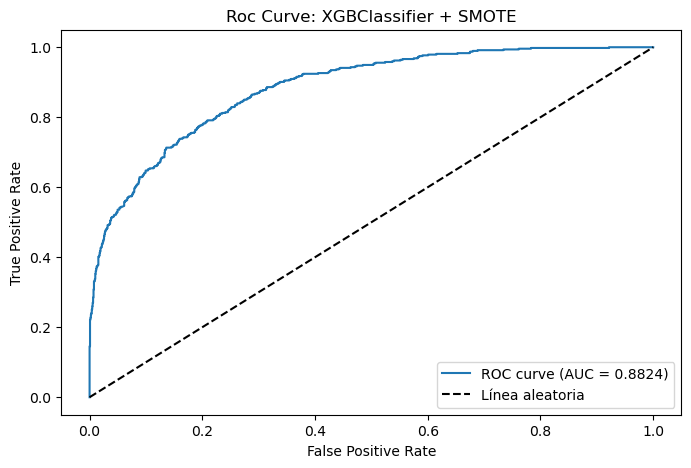

In [35]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=12345)

xgb_param_grid = {'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 5, 7],
            'clf__learning_rate': [0.01, 0.1, 0.2],
            'clf__subsample': [0.7, 0.8, 1.0]}

best_xgb_model = train_model(X_train, y_train, xgb_model, xgb_param_grid)
xgb_test_pred, xgb_test_proba, xgb_metrics = evaluate_model(best_xgb_model, X_train, y_train, X_test, y_test)
xgb_roc_auc = roc_curve_gph(y_test, xgb_test_proba, model_name='XGBClassifier')

El modelo XGBoost tiene un gran redimiento para clasificar clases con un AUC del 88%. Es capaz de predecir correctamente al 82% de los clientes (accuracy).  El 67% de las predicciones de cancelación son correctas, que podría traducirse en mejor empleo de recursos de promoción y fidelización. La curva ROC está muy por encima de la diagonal aleatoria y tiene mayor inclinación hacia la esquina superior izquierda.

#### 5.3.6. Red neuronal

c:\Users\Daniela\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6398 - auc: 0.7138 - loss: 0.6313

c:\Users\Daniela\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,auc,loss
  current = self.get_monitor_value(logs)
c:\Users\Daniela\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,auc,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
c:\Users\Daniela\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7014 - auc: 0.7731 - loss: 0.5806 - learning_rate: 0.0010
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7667 - auc: 0.8262 - loss: 0.5179 - learning_rate: 0.0010
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7677 - auc: 0.8393 - loss: 0.5015 - learning_rate: 0.0010
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7785 - auc: 0.8491 - loss: 0.4867 - learning_rate: 0.0010
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7804 - auc: 0.8501 - loss: 0.4864 - learning_rate: 0.0010
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7790 - auc: 0.8513 - loss: 0.4830 - learning_rate: 0.0010
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7822 - auc: 0.8572 - loss: 0.4754 - learning_rate: 0.0010
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7901 - auc: 0.8605 - loss: 0.4707 - learning_rate: 0.0010
Epoch 9/20
243/243

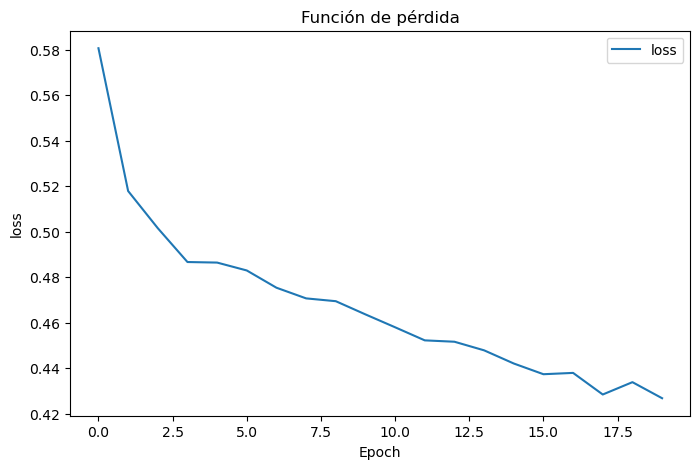

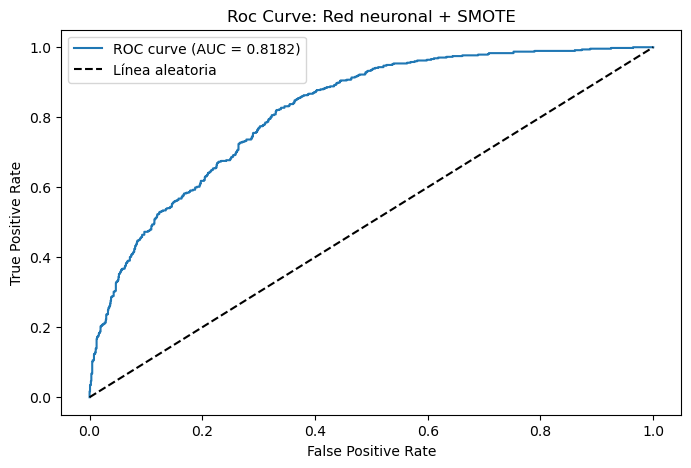

In [ ]:
#Preprocesamiento
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

#Modelo
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape= (X_train_p.shape[1],)))
nn_model.add(Dropout(0.3))

nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.3))

nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dropout(0.3))

nn_model.add(Dense(1, activation='sigmoid'))


X_train_smote, y_train_smote = SMOTE(random_state=12345).fit_resample(X_train_p, y_train)


nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

#Entrenar
history = nn_model.fit(X_train_smote, y_train_smote, epochs=20, batch_size=32, callbacks=cb, verbose=1)

#Predicciones
y_proba_nn = nn_model.predict(X_test_p).flatten()
y_pred_nn = (y_proba_nn > 0.6).astype(int)

y_proba_nn_train = nn_model.predict(X_train_smote).flatten()
y_pred_nn_train = (y_proba_nn_train > 0.6).astype(int)

auc_roc_test_nn = roc_auc_score(y_test, y_proba_nn)
auc_roc_train_nn = roc_auc_score(y_train_smote, y_proba_nn_train)
accuracy_test_nn = accuracy_score(y_test, y_pred_nn)
accuracy_train_nn = accuracy_score(y_train_smote, y_pred_nn_train)

metrics_nn = {'AUC_ROC_train': auc_roc_train_nn,
                'AUC_ROC_test': auc_roc_test_nn,
                'Accuracy_train': accuracy_train_nn,
                'Accuracy_test': accuracy_test_nn}


print(metrics_nn)
print('Classification_report:')
print(classification_report(y_test, y_pred_nn))

#Gráfica de la función de pérdida
hist = history.history
plt.figure(figsize=(8,5))
plt.plot(hist['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Función de pérdida')
plt.legend()
plt.show()

#Gráfica de la curva ROC
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_proba_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize = (8,5))
plt.plot(fpr_nn, tpr_nn, label=f'ROC curve (AUC = {roc_auc_nn:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')
plt.title(f'Roc Curve: Red neuronal + SMOTE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show() 

El modelo de red neuronal tiene gran capacidad para clasificar clases con un AUC de 81.8%. Predice correctamente al 75% de los clientes. Tiene una precisión del 54% e identifica correctamente al 60% de los clientes que realmente cancelaron. Se observa cierto sobreajuste en el modelo.

La gráfica de la función de pérdida indica que disminuye a lo largo de 20 épocas mostrando un aprendizaje constante.

In [43]:
#Cuadro comparativo de métricas

all_models = pd.DataFrame.from_dict({'Logistic Regression': lr_metrics,
                          'Decision Tree': dt_metrics,
                          'Random Forest': rf_metrics,
                          'XGBoost': xgb_metrics,
                          'Red neuronal': metrics_nn})
all_models

,Logistic Regression,Decision Tree,Random Forest,XGBoost,Red neuronal
AUC_ROC_train,0.850317,0.848514,0.926706,0.930849,0.909559
AUC_ROC_test,0.837939,0.837245,0.844640,0.882425,0.818209
Accuracy_train,0.751988,0.764105,0.853086,0.872775,0.833033
Accuracy_test,0.741056,0.744463,0.782510,0.821692,0.755253


## 6. Informe y conclusiones


- El modelo más adecuado para implementar en la empresa Interconnect es el modelo XGBoost, ya que tiene un gran rendimiento presentando el AUC más alto (88.24%) y gran eficiencia con un accuracy del 82%. Identifica correctamente al 66% de los clientes que realmente cancelaron sus planes y de todas las veces que predice abandono acierta el 67% de las veces. 
- Las variables de antigüedad (tenure) y cargos mensuales son factores clave para analizar al momento de evaluar las cancelaciones. La mayoría de los clientes que cancelan son relativamente nuevos y tienen costos mensuales relativamente altos.
- Se recomienda promocionar los servicios complementarios de internet que muestran mayor fidelización.


¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

Se realizaron todos los pasos del plan de trabajo, sin embargo, se adicionó la fase de inicialización donde se cargaron las librerías. Por otra parte, el apartado de ingeniería de características se incluyó en el preprocesamiento de datos y no en la fase de EDA. Asimismo, se incluyeron nuevos apartados en los distintos pasos presentados en el plan de trabajo, como el análisis de correlaciones, valores atípicos, pruebas de hipótesis y la creación de funciones.

¿Qué dificultades encontraste y cómo lograste resolverlas?

- La primera dificultad fue la transformación de la variable objetivo que se presentaba con un tipo de datos de object, esto se resolvió con la creación de una nueva variable objetivo a partir de EndDate, transformando el tipo de datos a numérico y binario, generando 1 para todos los valores distintos a NO y 0 para el resto de datos. 
- Los valores nulos encontrados a partir de la unión de dataframes, fueron interpretados e imputados como servicio no contratado por el cliente.
- Otra gran dificultad fue identificar el desequilibrio de clases que condicionaba todo el análisis y cualquier modelo que se entrenara y evaluara. Esta dificultad fue resuelta aplicando SMOTE en el entrenamiento de los modelos para generar el sobremuestreo de la clase minoritaria.

¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

- El preprocesamiento de datos fue uno de los pasos más importantes para resolver el proyecto, ya que en este paso se convirtieron las variables a los tipos de datos correctos, se trataron los valores nulos y se generó la variable objetivo.
- Identificación del desequilibrio de clases y aplicación de SMOTE para el balanceo.
- Estandarización de características numéricas con StandardScaler y conversión de variables categóricas en numéricas con OneHotEncoder.
- La creación de funciones fue determinante para generar un proceso reutilizable y evitar tareas repetitivas, de esta manera se logró evaluar más modelos potenciales.

¿Cuál es tu modelo final y qué nivel de calidad tiene?

El modelo seleccionado finalmente corresponde al XGBoost Classifier, que obtuvo el mejor rendimiento con un AUC-ROC de 0.88 que determina gran capacidad para distinguir entre clases. Tiene un accuracy de 0.82, es decir, que es capaz de predecir correctamente el 82% de los clientes. Presenta un 67% de predicciones de cancelación correctas y tiene un balance aceptable entre precision y recall.

